In [16]:
# Snippet 1
import requests
import json
import folium
from functools import lru_cache
from shapely.geometry import LineString

# Please add your API key for Google Maps Directions API
API_KEY = ''

# Create a cache for route calculations
@lru_cache(maxsize=None)
def calculate_route(origin, destination):
    url = f'https://maps.googleapis.com/maps/api/directions/json?origin={origin[0]},{origin[1]}&destination={destination[0]},{destination[1]}&mode=walking&key={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data


# Read the data from the CSV file and extract the conflict zone and camp locations
conflict_zone_locations = []
camp_locations = []

with open('locations.csv', 'r') as file:
    lines = file.readlines()[1:]  # Skip the header line
    for line in lines:
        fields = line.strip().split(',')
        location_name = fields[0]
        location_coordinates = (float(fields[3]), float(fields[4]))
        location_type = fields[5]
        if location_type == 'conflict_zone':
            conflict_zone_locations.append((location_name, location_coordinates))
        elif location_type == 'camp':
            camp_locations.append((location_name, location_coordinates))

# Process each conflict zone
features = []
for zone1 in conflict_zone_locations + camp_locations:
    zone1_name, zone1_coordinates = zone1

    # Calculate routes from the current location to all other conflict zones and camps
    routes = []
    for zone2 in conflict_zone_locations + camp_locations:
        zone2_name, zone2_coordinates = zone2

        # Skip if the locations are the same
        if zone1_name == zone2_name:
            continue

        try:
            # Calculate the route or retrieve from cache
            data = calculate_route(zone1_coordinates, zone2_coordinates)

            # Check if the route is found
            if data['status'] == 'OK':
                # Extract the route coordinates
                coordinates = []
                for step in data['routes'][0]['legs'][0]['steps']:
                    start_location = step['start_location']
                    end_location = step['end_location']
                    coordinates.append((start_location['lat'], start_location['lng']))
                    coordinates.append((end_location['lat'], end_location['lng']))

                # Create a LineString object from the route coordinates
                route_line = LineString(coordinates)

                # Simplify the LineString by reducing the number of points
                tolerance = 0.001  # Adjust the tolorance "up" for more and "down" for fewrer coordinates 
                simplified_route = route_line.simplify(tolerance)

                # Extract the simplified coordinates from the LineString object
                simplified_coordinates = list(simplified_route.coords)

                routes.append({
                    'name': zone2_name,
                    'coordinates': simplified_coordinates
                })

            else:
                print(f"No route found between {zone1_name} and {zone2_name}")

        except Exception as e:
            print(f"Error occurred: {e}")

    # Add the routes as features to the GeoJSON
    if routes:
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "MultiLineString",
                "coordinates": [route['coordinates'] for route in routes]
            },
            "properties": {
                "start": {
                    "name": zone1_name,
                    "coordinates": simplified_coordinates
                },
                "routes": routes
            }
        }
        features.append(feature)

# Create the GeoJSON object
geojson = {
    "type": "FeatureCollection",
    "features": features
}


# Printouts for total number of coordinates in GeoJson file and between routes 
total_coordinates = 0

# Iterate over the features and calculate the total number of coordinates
for feature in geojson['features']:
    coordinates = feature['geometry']['coordinates'][0]
    total_coordinates += len(coordinates)

print("Total number of coordinates in the GeoJSON file (excluding start/end):", total_coordinates)

# Iterate over the features and count the number of coordinates per route
for feature in geojson['features']:
    coordinates = feature['geometry']['coordinates'][0]
    num_coordinates = len(coordinates)
    print(f"Route: {feature['properties']['start']['name']} to {feature['properties']['routes'][0]['name']} with {num_coordinates} coordinates.")


# Save the GeoJSON to a file
with open("routes.geojson", "w") as file:
    json.dump(geojson, file)

print("GeoJSON file saved successfully.")

# Read the GeoJSON file
with open('routes.geojson') as f:
    data = json.load(f)

# Calculate the center location based on all coordinates
all_coordinates = [coord for _, coord in conflict_zone_locations + camp_locations]
m = folium.Map(location=all_coordinates[0], zoom_start=6)

# Iterate over the features and add them as PolyLine to the map
for feature in data['features']:
    coordinates = feature['geometry']['coordinates'][0]
    folium.PolyLine(locations=coordinates, color='blue').add_to(m)

# Add conflict zones as green circles
for zone in conflict_zone_locations:
    zone_name, zone_coordinates = zone
    folium.CircleMarker(location=zone_coordinates, 
                        radius=6, color='red', 
                        fill=True, fill_color='red').add_to(m)
    folium.Marker(
        location=zone_coordinates, 
        popup=zone_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Add camps as red circles
for camp in camp_locations:
    camp_name, camp_coordinates = camp
    folium.CircleMarker(location=camp_coordinates, 
                        radius=6, color='green', 
                        fill=True, fill_color='green').add_to(m)
    folium.Marker(
        location=camp_coordinates,
        tooltip=camp_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Save the map as an HTML file
m.save('map.html')

# Display the map
m


Total number of coordinates in the GeoJSON file (excluding start/end): 542
Route: Gao to Segou with 39 coordinates.
Route: Segou to Gao with 41 coordinates.
Route: Tombouctou to Gao with 14 coordinates.
Route: Douentza to Gao with 8 coordinates.
Route: Kayes to Gao with 68 coordinates.
Route: Sikasso to Gao with 37 coordinates.
Route: Koulikoro to Gao with 56 coordinates.
Route: Menaka to Gao with 12 coordinates.
Route: Kidal to Gao with 12 coordinates.
Route: Bamako to Gao with 49 coordinates.
Route: Fassala to Gao with 40 coordinates.
Route: Mentao to Gao with 20 coordinates.
Route: Dori to Gao with 20 coordinates.
Route: Damba to Gao with 21 coordinates.
Route: Djibo to Gao with 21 coordinates.
Route: Niamey to Gao with 16 coordinates.
Route: Mangaize to Gao with 14 coordinates.
Route: Ayorou to Gao with 8 coordinates.
Route: Tahoua to Gao with 30 coordinates.
Route: Abala to Gao with 16 coordinates.
GeoJSON file saved successfully.


In [2]:
# Snippet 2
import requests
import json
import folium
from functools import lru_cache
from shapely.geometry import LineString
from multiprocessing import Pool, cpu_count

# API key for Google Maps Directions API
API_KEY = ''

# Create a cache for route calculations
@lru_cache(maxsize=None)
def calculate_route(origin, destination):
    url = f'https://maps.googleapis.com/maps/api/directions/json?origin={origin[0]},{origin[1]}&destination={destination[0]},{destination[1]}&mode=walking&key={API_KEY}'
    response = requests.get(url)
    data = response.json()
    return data

# Define a function to calculate the route for a given pair of locations
def calculate_route_for_pair(zone1, zone2):
    zone1_name, zone1_coordinates = zone1
    zone2_name, zone2_coordinates = zone2

    # Skip if the locations are the same
    if zone1_name == zone2_name:
        return None

    try:
        # Calculate the route or retrieve from cache
        data = calculate_route(zone1_coordinates, zone2_coordinates)

        # Check if the route is found
        if data['status'] == 'OK':
            # Extract the route coordinates
            coordinates = []
            for step in data['routes'][0]['legs'][0]['steps']:
                start_location = step['start_location']
                end_location = step['end_location']
                coordinates.append((start_location['lat'], start_location['lng']))
                coordinates.append((end_location['lat'], end_location['lng']))

            # Create a LineString object from the route coordinates
            route_line = LineString(coordinates)

            # Simplify the LineString by reducing the number of points
            tolerance = 0.0001  # Adjust the tolerance "up" for more and "down" for fewer coordinates
            simplified_route = route_line.simplify(tolerance)

            # Extract the simplified coordinates from the LineString object
            simplified_coordinates = list(simplified_route.coords)

            return {
                'name': zone2_name,
                'coordinates': simplified_coordinates
            }

        else:
            print(f"No route found between {zone1_name} and {zone2_name}")

    except Exception as e:
        print(f"Error occurred: {e}")

    return None

# Read the data from the CSV file and extract the conflict zone and camp locations
conflict_zone_locations = []
camp_locations = []

with open('locations.csv', 'r') as file:
    lines = file.readlines()[1:]
    for line in lines:
        fields = line.strip().split(',')
        location_name = fields[0]
        location_coordinates = (float(fields[3]), float(fields[4]))
        location_type = fields[5]
        if location_type == 'conflict_zone':
            conflict_zone_locations.append((location_name, location_coordinates))
        elif location_type == 'camp':
            camp_locations.append((location_name, location_coordinates))

# Process each conflict zone
features = []
num_locations = len(conflict_zone_locations + camp_locations)
num_pairs = num_locations * (num_locations - 1)

# Create a list of location pairs for parallel processing
location_pairs = []
for zone1 in conflict_zone_locations + camp_locations:
    for zone2 in conflict_zone_locations + camp_locations:
        location_pairs.append((zone1, zone2))


# Define a function to calculate routes for a batch of location pairs
def calculate_routes_batch(location_pairs):
    routes = []
    for zone1, zone2 in location_pairs:
        route = calculate_route_for_pair(zone1, zone2)
        if route:
            routes.append(route)
    return routes


# Split the location pairs into chunks for parallel processing
num_processes = cpu_count()
chunk_size = num_pairs // num_processes
chunks = [location_pairs[i:i+chunk_size] for i in range(0, num_pairs, chunk_size)]

# Create a multiprocessing Pool and map the chunks to worker processes
with Pool(processes=num_processes) as pool:
    results = pool.map(calculate_routes_batch, chunks)

# Flatten the results from all processes
routes = [route for result in results for route in result if route]

# Add the routes as features to the GeoJSON
for zone1 in conflict_zone_locations + camp_locations:
    zone1_name, zone1_coordinates = zone1
    zone_routes = [route for route in routes if route['name'] == zone1_name]
    if zone_routes:
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "MultiLineString",
                "coordinates": [route['coordinates'] for route in zone_routes]
            },
            "properties": {
                "start": {
                    "name": zone1_name,
                    "coordinates": zone1_coordinates
                },
                "routes": zone_routes
            }
        }
        features.append(feature)

# Create the GeoJSON object
geojson = {
    "type": "FeatureCollection",
    "features": features
}

# Save the GeoJSON to a file
with open("routes.geojson", "w") as file:
    json.dump(geojson, file)

print("GeoJSON file saved successfully.")

# Read the GeoJSON file
with open('routes.geojson') as f:
    data = json.load(f)

# Calculate the center location based on all coordinates
all_coordinates = [coord for _, coord in conflict_zone_locations + camp_locations]
m = folium.Map(location=all_coordinates[0], zoom_start=6)

# Iterate over the features and add them as PolyLine to the map
for feature in data['features']:
    coordinates = feature['geometry']['coordinates'][0]
    folium.PolyLine(locations=coordinates, color='blue').add_to(m)

# Add conflict zones as green circles
for zone in conflict_zone_locations:
    zone_name, zone_coordinates = zone
    folium.CircleMarker(location=zone_coordinates, 
                        radius=6, color='red', 
                        fill=True, fill_color='red').add_to(m)
    folium.Marker(
        location=zone_coordinates, 
        popup=zone_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Add camps as red circles
for camp in camp_locations:
    camp_name, camp_coordinates = camp
    folium.CircleMarker(location=camp_coordinates, 
                        radius=6, color='green', 
                        fill=True, fill_color='green').add_to(m)
    folium.Marker(
        location=camp_coordinates,
        tooltip=camp_name,
        icon=folium.DivIcon(icon_size=(1,1))
    ).add_to(m)

# Save the map as an HTML file
m.save('map.html')

# Display the map
m

GeoJSON file saved successfully.


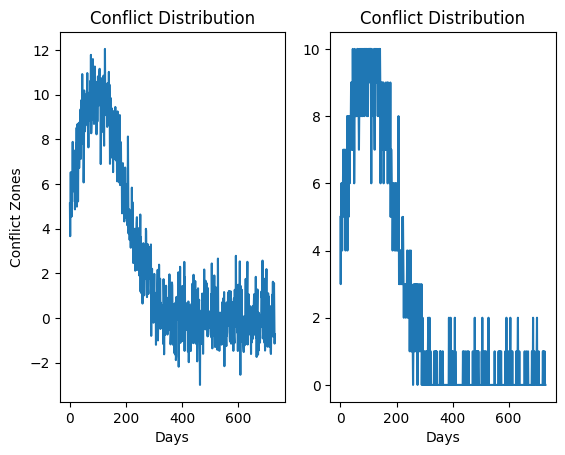

In [1]:
# Snippet 3
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt


# Custom function to generate all zeros csv file
def generate_conflict_zones_csv(filename, conflict_zones, period):
    data = {'#Days': list(range(period))}
    data.update({zone: [0] * period for zone in conflict_zones})
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)

    
# Custom distribution function 1
def custom_distribution1(x):
    peak_day = 100
    max_value = 10
    std_deviation = 130
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor = np.exp(-((x - peak_day) / std_deviation) ** 2)
    
    # Add random fluctuations to the spreading factor
    spreading_factor += np.random.normal(0, variation_factor, len(x))
    
    y = max_value * spreading_factor
    return y


# Custom distribution function 2
def custom_distribution2(x):
    peak_day = 100
    max_value = 10
    std_deviation = 100
    rise_factor = 1.5
    fall_factor = 0.125
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor_rising = np.exp(-((x - peak_day) / std_deviation) ** 2) ** rise_factor
    spreading_factor_falling = np.exp(-((x - peak_day) / (std_deviation * 2)) ** 2) ** fall_factor
    
    # Add random fluctuations to the spreading factors
    spreading_factor_rising += np.random.normal(0, variation_factor, len(x))
    spreading_factor_falling += np.random.normal(0, variation_factor, len(x))
    
    y_rising = max_value * spreading_factor_rising
    y_falling = max_value * spreading_factor_falling
    y = np.where(x < peak_day, y_rising, y_falling)
    return y


# Custom distribution function 3
def custom_distribution3(x):
    peak1_day = 150
    peak2_day = 650
    max_value = 10
    std_deviation1 = 30
    std_deviation2 = 50
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor1 = np.exp(-((x - peak1_day) / std_deviation1) ** 2)
    spreading_factor2 = np.exp(-((x - peak2_day) / std_deviation2) ** 2)
    
    # Add random fluctuations to the spreading factors
    spreading_factor1 += np.random.normal(0, variation_factor, len(x))
    spreading_factor2 += np.random.normal(0, variation_factor, len(x))
    
    y = max_value * (spreading_factor1 + spreading_factor2)
    return y


# Custom distribution function 4
def custom_distribution4(x):
    peak1_day = 150
    peak2_day = 650
    max_value = 10
    std_deviation1 = 30
    std_deviation2 = 50
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factor1 = np.exp(-((x - peak1_day) / std_deviation1) ** 2)
    spreading_factor2 = np.exp(-((x - peak2_day) / std_deviation2) ** 2)
    
    # Add random fluctuations to the spreading factors
    spreading_factor1 += np.random.normal(0, variation_factor, len(x))
    spreading_factor2 += np.random.normal(0, variation_factor, len(x))
    
    y = max_value * (spreading_factor1 + spreading_factor2)
    return y


# Custom distribution function 5
def custom_distribution5(x):
    peaks = [100, 200, 300, 400, 500]  # Adjust the peak days as desired
    max_value = 10
    std_deviations = [10, 10, 10, 10, 10]  # Adjust the standard deviations as desired
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factors = []
    for peak, std_deviation in zip(peaks, std_deviations):
        spreading_factor = np.exp(-((x - peak) / std_deviation) ** 2)
        spreading_factor += np.random.normal(0, variation_factor, len(x))
        spreading_factors.append(spreading_factor)
    
    y = max_value * sum(spreading_factors)
    return y


# Custom distribution function 6
def custom_distribution6(x):
    peaks = [150, 300, 450, 600]  # Adjust the peak days as desired
    hill_width = 20  # Adjust the width of the hill
    max_value = 10
    std_deviations = [10, 20, 30, 40]  # Adjust the standard deviations as desired
    variation_factor = 0.1  # Adjust the variation factor as desired
    
    spreading_factors = []
    for peak, std_deviation in zip(peaks, std_deviations):
        spreading_factor = np.exp(-((x - peak) / std_deviation) ** 2)
        
        # Create the hill shape by adding a flat plateau around the peak
        hill_mask = np.logical_and(x >= peak - hill_width, x <= peak + hill_width)
        spreading_factor[hill_mask] = max_value
        
        spreading_factor += np.random.normal(0, variation_factor, len(x))
        spreading_factors.append(spreading_factor)
    
    y = max_value * sum(spreading_factors)
    return y


# Custom distribution function 7
def custom_distribution7(x):
    period = 365  # Length of one complete period (in days)
    max_value = 10  # Maximum value for conflict intensity
    variation_factor = 0.5  # Adjust the variation factor as desired
    
    # Compute the phase angle based on the day of the year
    phase_angle = (x % period) / period * 2 * np.pi
    
    # Use a sine function to model the seasonal variation
    y = max_value * np.sin(phase_angle)
    
    # Add random noise with the specified variation factor
    y += np.random.normal(0, variation_factor, len(x))
    
    return y



# CSV Headers
conflict_zones = ['Gao', 'Segou', 'Tombouctou', 'Douentza', 'Kayes', 'Sikasso', 'Koulikoro', 'Menaka', 'Kidal', 'Bamako']

# Specify the simulation period
period = 732

# Call the function to generate all zeros csv file
generate_conflict_zones_csv('modified-conflicts.csv', conflict_zones, period)

# Read the CSV file into a DataFrame
df = pd.read_csv("modified-conflicts.csv")

# Generate x-axis values from 0 to 731
x = np.linspace(0, 731, num=732)

# Compute y-axis values using the custom distribution function
y = custom_distribution1(x)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot graph
ax1.plot(x, y)
ax1.set_title('Conflict Distribution')
ax1.set_xlabel('Days')
ax1.set_ylabel('Conflict Zones')

# Convert y values to integers
y = [int(val) for val in y]

modified_rows = []
y_index = 0
for _, row in df.iterrows():
    row = row.values
    if y_index >= len(y):
        break

    number = y[y_index]
    y_index += 1
    assigned_count = 0
    for i in range(1, len(row)):
        if assigned_count < number:
            row[i] = 1
            assigned_count += 1
        else:
            break

    modified_rows.append(row)

# Create modified DataFrame
modified_df = pd.DataFrame(modified_rows, columns=df.columns)

# Compute the sum of each row (excluding the '#Days' column)
sum_values = modified_df.iloc[:, 1:].sum(axis=1)

# Plot the summed values
ax2.plot(x, sum_values)
ax2.set_title('Conflict Distribution')
ax2.set_xlabel('Days')

# Write the modified DataFrame to the CSV file
modified_df.to_csv('modified-conflicts.csv', index=False)
